In [31]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
import scipy
import random
import pandas as pd

In [32]:
random.seed(189004)

In [33]:
data = scipy.io.loadmat("/Users/jose/Downloads/hw4/data.mat")

In [34]:
X_train = data['X'] 
X_labels = data['y'] 
test_data = data['X_test']

In [35]:
import sklearn.model_selection
X_train, X_holdout, y_train, y_holdout = sklearn.model_selection.train_test_split(X_train, X_labels, test_size=1000, random_state=189004)

In [36]:
#normalize data
norm_X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
norm_X_holdout = (X_holdout - np.mean(X_train, axis=0)) / np.std(X_train, axis=0) 
norm_test_data = (test_data - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

In [37]:
# Add fictitious dimension to train and test sets.
norm_X_train = np.array([np.append(i, 1) for i in norm_X_train]) 
norm_X_holdout = np.array([np.append(i, 1) for i in norm_X_holdout]) 
norm_test_data = np.array([np.append(i, 1) for i in norm_test_data])

In [38]:
norm_X_train.shape 
norm_X_holdout.shape 
norm_test_data.shape 
y_train.shape 
y_holdout.shape

(1000, 1)

In [39]:
y_train = y_train.flatten()
y_holdout = y_holdout.flatten()

### Problem 3.1: Batch Gradient Descent Update

The gradient descent update law for logistic regression with $\ell_2$ regularization is
$$w^{(n+1)} = w^{(n)} - \lambda X(s(Xw) - y)$$
Where $\lambda$ is a tuneable hyperparameter, $w$ are the weights we are updating, $X$ is our input matrix, $y$ is our labels, and $s$ is the sigmoid function

### Problem 3.2: Batch Gradient Descent Code

In [42]:
# Returns w after one iteration of gradient descent.
def one_iteration_gradient_descent(w, l, X, y): # w = weights
    # l = lambda
    # X = design matrix
    # y = labels
    # Returns: w after one update.
    right_term = X @ w
    right_term = scipy.special.expit(right_term) - y 
    right_term = l * X.T @ right_term
    return w - right_term
# Calculates logistic regression for input X based on weights w.
def logistic_regression(w, X): # w = weights
    # X = input for prediction
    temp = scipy.special.expit(X @ w)
    return np.array([1 if i >= 0.5 else 0 for i in temp])

In [43]:
# Calculates error 
def calculate_error(estimates, actual): 
    correct = 0
    assert len(estimates) == len(actual)
    for i in range(len(estimates)): 
        if estimates[i] == actual[i]:
            correct += 1
    return 1 - correct / len(estimates)
# Calculates cost for us
def calculate_cost(w, X, y):
    t = scipy.special.expit(X @ w)
    t2 = scipy.special.expit(1 - (X @ w))
    cost = np.dot(y, np.log(t + 0.01)) + np.dot((1-y), np.log(t2 + 0.01)) 
    return -cost

In [45]:
w = np.ones(13) 
w

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [47]:
# Gradient Descent Loop
steps = 1001
learning_rate = 0.1
costs, iterations = np.array([]), np.array([]) 
for i in range(steps):
    w = one_iteration_gradient_descent(w, learning_rate, norm_X_train, y_train) 
    if i % 50 == 0:
        predictions = logistic_regression(w, norm_X_train) 
        err = calculate_error(predictions, y_train)
        cost = calculate_cost(w, norm_X_train, y_train) 
        costs = np.append(costs, cost)
        iterations = np.append(iterations, i)
        print(f"{i} Iterations || Error Rate: {round(err, 4)} || Cost: {round(err, 4)}")


0 Iterations || Error Rate: 0.104 || Cost: 0.104
50 Iterations || Error Rate: 0.0072 || Cost: 0.0072
100 Iterations || Error Rate: 0.0058 || Cost: 0.0058
150 Iterations || Error Rate: 0.0062 || Cost: 0.0062
200 Iterations || Error Rate: 0.0065 || Cost: 0.0065
250 Iterations || Error Rate: 0.0068 || Cost: 0.0068
300 Iterations || Error Rate: 0.006 || Cost: 0.006
350 Iterations || Error Rate: 0.0072 || Cost: 0.0072
400 Iterations || Error Rate: 0.0062 || Cost: 0.0062
450 Iterations || Error Rate: 0.0062 || Cost: 0.0062
500 Iterations || Error Rate: 0.0065 || Cost: 0.0065
550 Iterations || Error Rate: 0.0068 || Cost: 0.0068
600 Iterations || Error Rate: 0.006 || Cost: 0.006
650 Iterations || Error Rate: 0.0072 || Cost: 0.0072
700 Iterations || Error Rate: 0.0062 || Cost: 0.0062
750 Iterations || Error Rate: 0.0062 || Cost: 0.0062
800 Iterations || Error Rate: 0.0058 || Cost: 0.0058
850 Iterations || Error Rate: 0.0065 || Cost: 0.0065
900 Iterations || Error Rate: 0.0065 || Cost: 0.0065
95

Text(0.5, 1.0, 'Logistic Regression Cost After n Iterations of Batch GD')

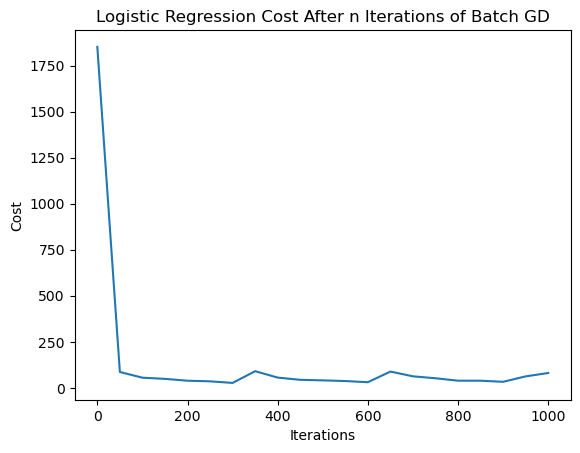

In [48]:
plt.plot(iterations, costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Logistic Regression Cost After n Iterations of Batch GD")

### Problem 3.3: Stochastic Gradient Descent (SGD) Update

The stochastic gradient descent update law for logistic regression with $\ell_2$ regularization is
$$w^{(n+1)} = w^{(n)} - \lambda (s(X_iw) - y_i)X_i$$
Where $\lambda$ is a tuneable hyperparameter, $w$ are the weights we are updating, $X$ is our input matrix, $y$ is our labels, and $s$ is the sigmoid function.

### Problem 3.4: Stochastic Gradient Descent Code

In [51]:
def one_stochastic_gradient_descent(w, l, X, y): 
    # w = weights
    # l = lambda
    # X = design matrix
    # y = labels
    # Returns: w after one update.
    t = random.randrange(0, len(y))
    right_term = X[t] @ w
    right_term = scipy.special.expit(right_term) - y[t] 
    right_term = l * right_term * X[t]
    return w - right_term

In [52]:
new_w = np.ones(13)

In [53]:
# Stochastic Gradient Descent Loop
steps = 1001
learning_rate = 0.1
costs2, iterations2 = np.array([]), np.array([]) 
for i in range(steps):
    new_w = one_stochastic_gradient_descent(new_w, learning_rate, norm_X_train, y_train) 
    if i % 50 == 0:
        predictions2 = logistic_regression(new_w, norm_X_train) 
        err2 = calculate_error(predictions2, y_train)
        cost2 = calculate_cost(new_w, norm_X_train, y_train) 
        costs2 = np.append(costs2, cost2)
        iterations2 = np.append(iterations2, i)
        print(f"{i} Iterations || Error Rate: {round(err2, 4)} || Cost: {round(err2, 4)}")


0 Iterations || Error Rate: 0.4473 || Cost: 0.4473
50 Iterations || Error Rate: 0.097 || Cost: 0.097
100 Iterations || Error Rate: 0.0515 || Cost: 0.0515
150 Iterations || Error Rate: 0.0272 || Cost: 0.0272
200 Iterations || Error Rate: 0.0212 || Cost: 0.0212
250 Iterations || Error Rate: 0.0222 || Cost: 0.0222
300 Iterations || Error Rate: 0.0158 || Cost: 0.0158
350 Iterations || Error Rate: 0.0168 || Cost: 0.0168
400 Iterations || Error Rate: 0.014 || Cost: 0.014
450 Iterations || Error Rate: 0.014 || Cost: 0.014
500 Iterations || Error Rate: 0.0145 || Cost: 0.0145
550 Iterations || Error Rate: 0.0145 || Cost: 0.0145
600 Iterations || Error Rate: 0.0122 || Cost: 0.0122
650 Iterations || Error Rate: 0.012 || Cost: 0.012
700 Iterations || Error Rate: 0.0122 || Cost: 0.0122
750 Iterations || Error Rate: 0.013 || Cost: 0.013
800 Iterations || Error Rate: 0.012 || Cost: 0.012
850 Iterations || Error Rate: 0.0135 || Cost: 0.0135
900 Iterations || Error Rate: 0.017 || Cost: 0.017
950 Iterat

Text(0.5, 1.0, 'Logistic Regression Cost After n Iterations of Stochastic GD')

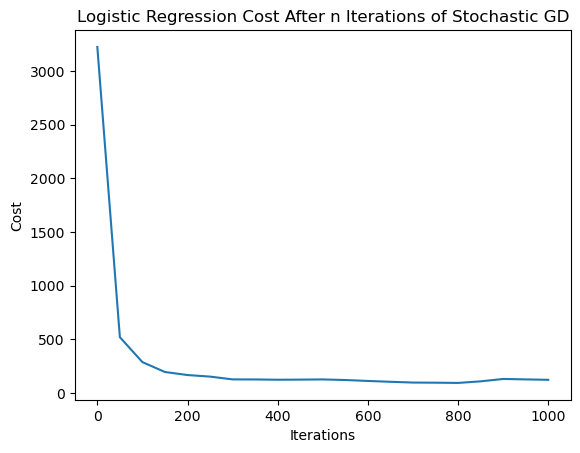

In [54]:
plt.plot(iterations2, costs2)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Logistic Regression Cost After n Iterations of Stochastic GD")

#### The batch Gradient Descent converged faster to its respective cost than the stochastic gradient descent. The plot of the stochastic gradient descent tells us that after many iterations, our solution seems to be more "stable" than our batch gradient descent plot. This is likely due to the nature of stochastic gradient descent and how it picks points randomly and as a result, takes much longer to converge to a stable point compared to if we looked at each gradient individually. However, it is the large gradient we calculate in batch gradient descent which makes our cost not very stable.


### Problem 3.5: SGD algorithm with new step size

In [56]:
def one_stochastic_gradient_descent_shrinking(w, l, X, y, iteration): 
    # w = weights
    # l = lambda
    # X = design matrix
    # y = labels
    # iteration = iter number
    # Returns: w after one update.
    t = random.randrange(0, len(y))
    right_term = X[t] @ w
    right_term = scipy.special.expit(right_term) - y[t] 
    if iteration == 0:
        iteration = 1
    right_term = l * right_term * X[t] / iteration 
    return w - right_term

In [57]:
new_w2 = np.ones(13)

In [59]:
# Decreasing Stochastic Gradient Descent Loop
steps = 1001
learning_rate = 5
costs3, iterations3 = np.array([]), np.array([]) 
for i in range(steps):
    new_w2 = one_stochastic_gradient_descent_shrinking(new_w2, learning_rate, norm_X_train, y_train, 50) 
    if i % 50 == 0:
        predictions3 = logistic_regression(new_w2, norm_X_train) 
        err3 = calculate_error(predictions3, y_train)
        cost3 = calculate_cost(new_w2, norm_X_train, y_train) 
        costs3 = np.append(costs3, cost3)
        iterations3 = np.append(iterations3, i)
        print(f"{i} Iterations || Error Rate: {round(err3, 4)} || Cost: {round(err3, 4)}")


0 Iterations || Error Rate: 0.4688 || Cost: 0.4688
50 Iterations || Error Rate: 0.124 || Cost: 0.124
100 Iterations || Error Rate: 0.0665 || Cost: 0.0665
150 Iterations || Error Rate: 0.0393 || Cost: 0.0393
200 Iterations || Error Rate: 0.027 || Cost: 0.027
250 Iterations || Error Rate: 0.0232 || Cost: 0.0232
300 Iterations || Error Rate: 0.018 || Cost: 0.018
350 Iterations || Error Rate: 0.015 || Cost: 0.015
400 Iterations || Error Rate: 0.0142 || Cost: 0.0142
450 Iterations || Error Rate: 0.0128 || Cost: 0.0128
500 Iterations || Error Rate: 0.0135 || Cost: 0.0135
550 Iterations || Error Rate: 0.013 || Cost: 0.013
600 Iterations || Error Rate: 0.0165 || Cost: 0.0165
650 Iterations || Error Rate: 0.0128 || Cost: 0.0128
700 Iterations || Error Rate: 0.0108 || Cost: 0.0108
750 Iterations || Error Rate: 0.0108 || Cost: 0.0108
800 Iterations || Error Rate: 0.0108 || Cost: 0.0108
850 Iterations || Error Rate: 0.0105 || Cost: 0.0105
900 Iterations || Error Rate: 0.01 || Cost: 0.01
950 Iterat

Text(0.5, 1.0, 'Logistic Regression Cost After n Iterations of Decreasing Stochastic GD')

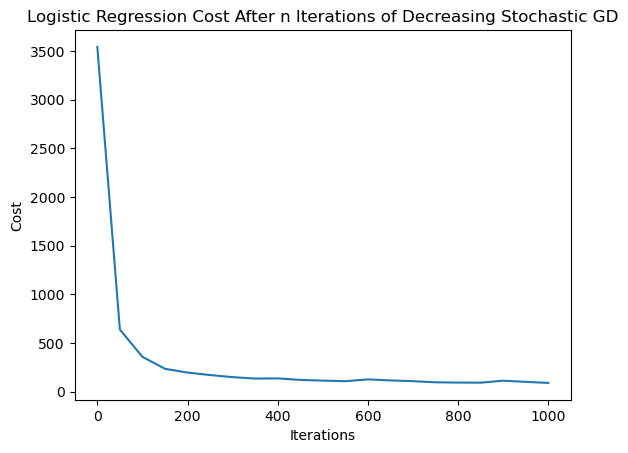

In [60]:
plt.plot(iterations3, costs3)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Logistic Regression Cost After n Iterations of Decreasing Stochastic GD")

#### This graph converges slower than our stochastic gradient descent, even seeing movement in the 500+ iterations range which may be due to the fact that we increased the number of iterations. This led to the learning rate slowing down and thus taking more iterations to make changes in our weights.

### Problem 3.6: Kaggle

#### Kaggle Username: Jose Fernandez
#### Kaggle Best Score: 0.986

In [61]:
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1 
    df.to_csv('submission.csv', index_label='Id')

In [62]:
final_predictions = logistic_regression(w, norm_test_data) 
final_predictions

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,

In [63]:
results_to_csv(final_predictions)

#### To achieve the score I got, I added an extra variable to our data to increase the dimensionality and add a linear term. I also performed batch gradient descent to minimize our logistic error function. After doing this, I ran my model on the test set and submitted those predictions.

### Problem  5.1: Plotting the isocontours (a), (b), and (c)

In [64]:
def half_norm(x, y):
    return (abs(x)**.5 + abs(y)**.5)**2
def norm(x, y):
    return abs(x)+abs(y)
def two_norm(x, y):
    return (x**2 + y**2)**.5

In [65]:
precision = 60
x1 = np.linspace(-5, 5, precision) 
x2 = np.linspace(-5, 5, precision) 
x1, x2 = np.meshgrid(x1, x2)

In [66]:
z_1 = half_norm(x1, x2) 
z_2 = norm(x1, x2)
z_3 = two_norm(x1, x2)

#### Part (a)

Text(0.5, 1.0, '$\\ell_{0.5}$-Norm')

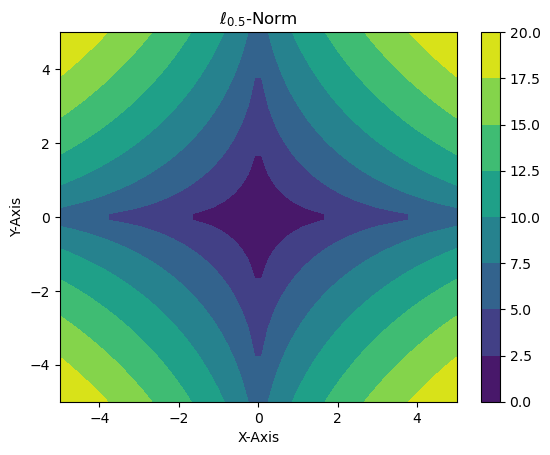

In [67]:
fig1 = plt.contourf(x1, x2, z_1) 
plt.colorbar(fig1) 
plt.xlabel("X-Axis") 
plt.ylabel("Y-Axis") 
plt.title("$\ell_{0.5}$-Norm")

#### Part (b)

Text(0.5, 1.0, '$\\ell_{1}$-Norm')

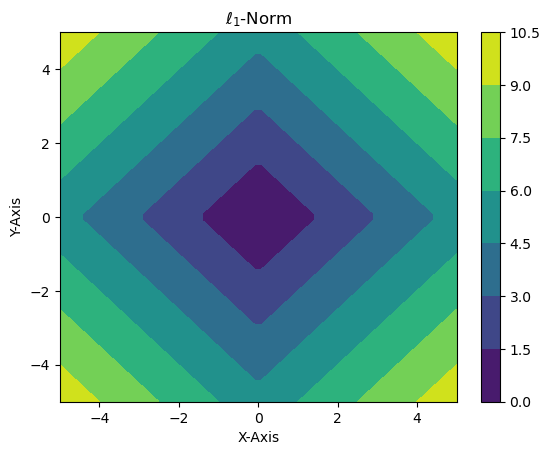

In [68]:
fig2 = plt.contourf(x1, x2, z_2) 
plt.colorbar(fig2) 
plt.xlabel("X-Axis") 
plt.ylabel("Y-Axis") 
plt.title("$\ell_{1}$-Norm")

#### Part (c)

Text(0.5, 1.0, '$\\ell_{2}$-Norm')

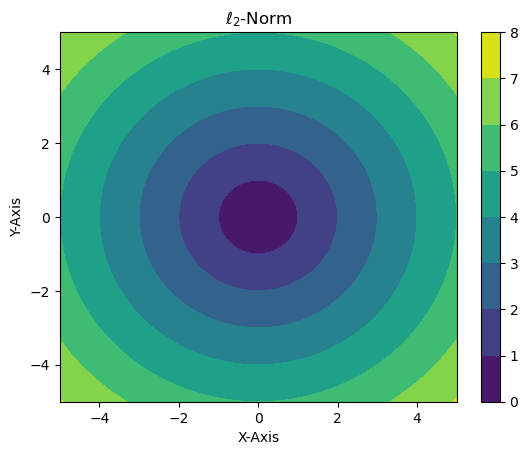

In [70]:
fig3 = plt.contourf(x1, x2, z_3) 
plt.colorbar(fig3) 
plt.xlabel("X-Axis") 
plt.ylabel("Y-Axis") 
plt.title("$\ell_{2}$-Norm")